In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
from datetime import datetime as dt 
import re

import streamlit as st

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
df = pd.read_csv("C:/Users/mosel/Documents/PYTHON/machine_learning/Netflix_Movies_and_TV_Shows_Clustering/NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.csv")

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [4]:
df.describe()

,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [6]:
df.shape

(7787, 12)

1.Data Cleaning 

In [7]:

# Check for null values.

for col in df.columns:
  null_rate = df[col].isnull().sum() / len(df) * 100
  if null_rate > 0:
    print(f'Percentage of null values in {col} : {null_rate}%')

Percentage of null values in director : 30.679337357133683%
Percentage of null values in cast : 9.220495697958135%
Percentage of null values in country : 6.51085141903172%
Percentage of null values in date_added : 0.1284191601386927%
Percentage of null values in rating : 0.08989341209708489%


In [8]:
#Handling null values / filling up it.

df[['director','cast','country']] = df[['director','cast','country']].fillna('unknown')
df[['rating']] = df[['rating']].fillna(df['rating'].mode()[0])
df.dropna(axis=0, inplace = True)

In [9]:

# Check for null values after fillna 

for col in df.columns:
  null_rate = df[col].isnull().sum() / len(df) * 100
  if null_rate > 0:
    print(f'Percentage of null values in {col} : {null_rate}%')

In [10]:
#To see the null values in date_added

df.date_added.isnull().sum()

np.int64(0)

In [11]:
# heck for the duplicate values 

df.duplicated().sum()

np.int64(0)

In [12]:
# shape of dataset after removing null and duplicate values 

df.shape

(7777, 12)

In [13]:
#Typecasting 'date_added' from string to datetime 

df['date_added'] = df['date_added'].str.strip()

df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

In [14]:
# Extract day, month, and year from valid datetime entries


df['month_added'] = df['date_added'].dt.month
df['year_added'] = df['date_added'].dt.year

In [15]:
df.drop('date_added',axis=1, inplace = True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7777 entries, 0 to 7786
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7777 non-null   object
 1   type          7777 non-null   object
 2   title         7777 non-null   object
 3   director      7777 non-null   object
 4   cast          7777 non-null   object
 5   country       7777 non-null   object
 6   release_year  7777 non-null   int64 
 7   rating        7777 non-null   object
 8   duration      7777 non-null   object
 9   listed_in     7777 non-null   object
 10  description   7777 non-null   object
 11  month_added   7777 non-null   int32 
 12  year_added    7777 non-null   int32 
dtypes: int32(2), int64(1), object(10)
memory usage: 789.9+ KB


2.EDA

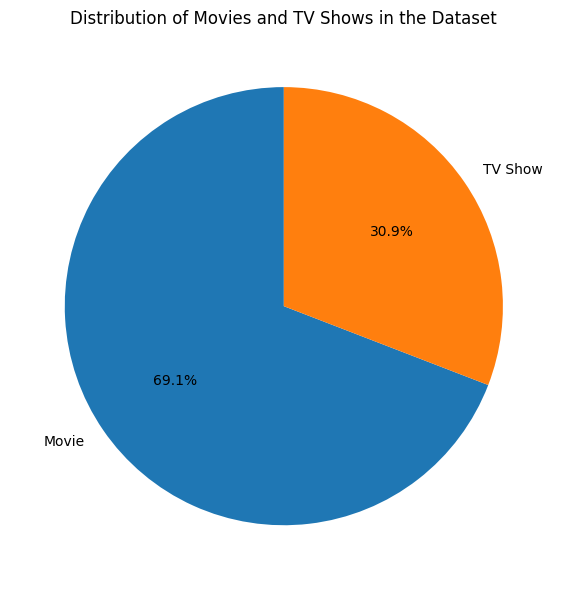

In [17]:
#1.Number of Movies and Tv shows in dataset
plt.figure(figsize=(6, 6))
df['type'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90)
plt.title('Distribution of Movies and TV Shows in the Dataset')
plt.ylabel('')  # Remove y-axis label
plt.tight_layout()
plt.show()

There are movies(69.14%) than Tv shows (30.86%) in the dataset

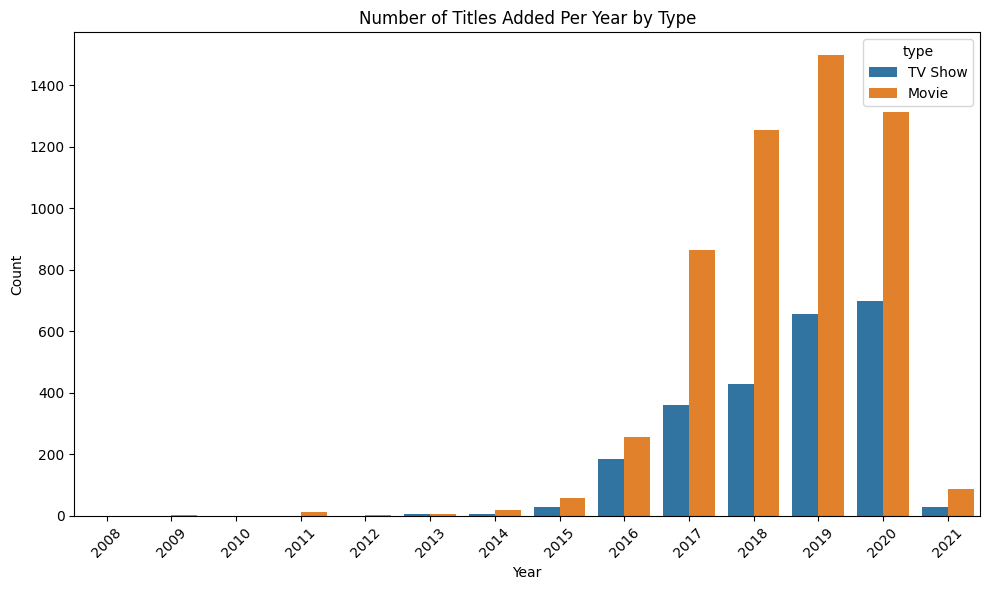

In [18]:
#2.Content growth over year
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='year_added', hue='type', order=sorted(df['year_added'].unique()))
plt.title('Number of Titles Added Per Year by Type')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


What is given in the chart ?

*2008–2014

 Very few titles were added.

 Minimal activity in both categories.

 Movies had a slight edge over TV shows in early years.

*2015–2016

 Noticeable increase in additions, especially in 2016.

 Growth begins for both categories, with Movies still leading.

*2017–2020

 Massive growth:In 2017, there’s a spike in the number of added titles, especially Movies (over 850).

 Growth continued through 2018 and peaked in 2019, when:

 Over 1,500 movies were added.

 Around 650–700 TV shows were added.

*2020 

 Maintained a high level but slightly dropped from 2019.

*2021 

 Sharp decline in additions for both types.

 Likely related to external factors such as production slowdowns during COVID-19 or changes in content strategy.

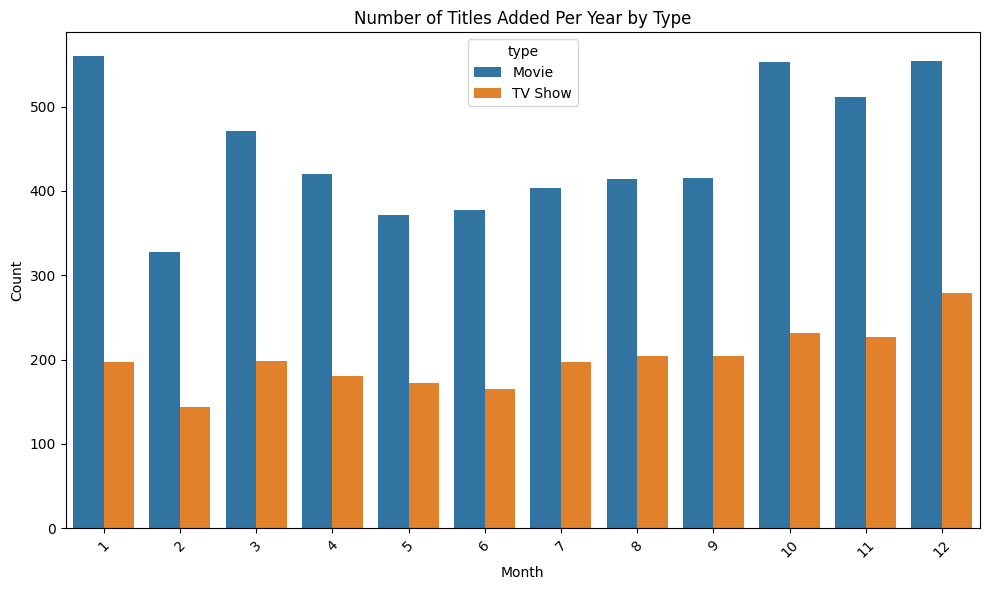

In [19]:
#3.Content growth over month
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='month_added', hue='type', order=sorted(df['month_added'].unique()))
plt.title('Number of Titles Added Per Year by Type')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observations:

*Movies Dominate Across All Months:

 Every month shows a significantly higher number of movies added compared to TV shows.

*High Movie Activity Months:

 January (Month 1), October (Month 10), and December (Month 12) show the highest number of movies added, each exceeding 500.

 This might be due to year-end updates, holiday releases, or licensing cycles.

*Low Movie Activity Months:

 February (Month 2) has the lowest number of movies added (~330), which might be a lull period post holidays.

*TV Shows Trend:

 Fairly consistent throughout the year.

 The lowest is in February, while the peak is in December with nearly 280 titles.

 TV show additions don’t fluctuate as much as movies, suggesting more consistent release patterns.

*Seasonal Patterns:

 Spikes in Movie additions in Q1 (January) and Q4 (October–December).

 TV Shows see a gradual build-up towards year-end.

In [20]:
#4.Content production by country


# Group by country and count the number of titles
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot Geo map
plt.figure(figsize=(10,6))
fig = px.choropleth(
    country_counts,
    locations='country',
    locationmode='country names',
    color='count',
    color_continuous_scale='Viridis',
    title='Content Production by Country',
)

fig.update_layout(geo=dict(showframe=False, projection_type='equirectangular'))

fig.show()


<Figure size 1000x600 with 0 Axes>

Key Insights:

***Top Producers:

United States is most likely the brightest, indicating it has the highest content production (often true in global streaming data).

Likely followed by countries like India, United Kingdom, Canada, and Japan—common hubs of film/TV production.

***Strong Regional Production:

Western Europe (e.g., France, Germany, UK, Spain) shows moderate-to-high production.

East Asia (e.g., South Korea, Japan, China) also shows a strong presence.

***Underrepresented Areas:

Sub-Saharan Africa, Central Asia, and some Middle Eastern nations appear less represented.

This could be due to: Fewer productions.

Licensing and distribution limitations.

Dataset biases.

In [21]:
#5.Top countries produce most of the content 

# Get top countries by content count 
top_countries=df['country'].value_counts().head(10)
print(f"Top Ten countries produce more content:")
top_countries




Top Ten countries produce more content:


country
United States     2549
India              923
unknown            506
United Kingdom     396
Japan              225
South Korea        183
Canada             177
Spain              134
France             115
Egypt              101
Name: count, dtype: int64

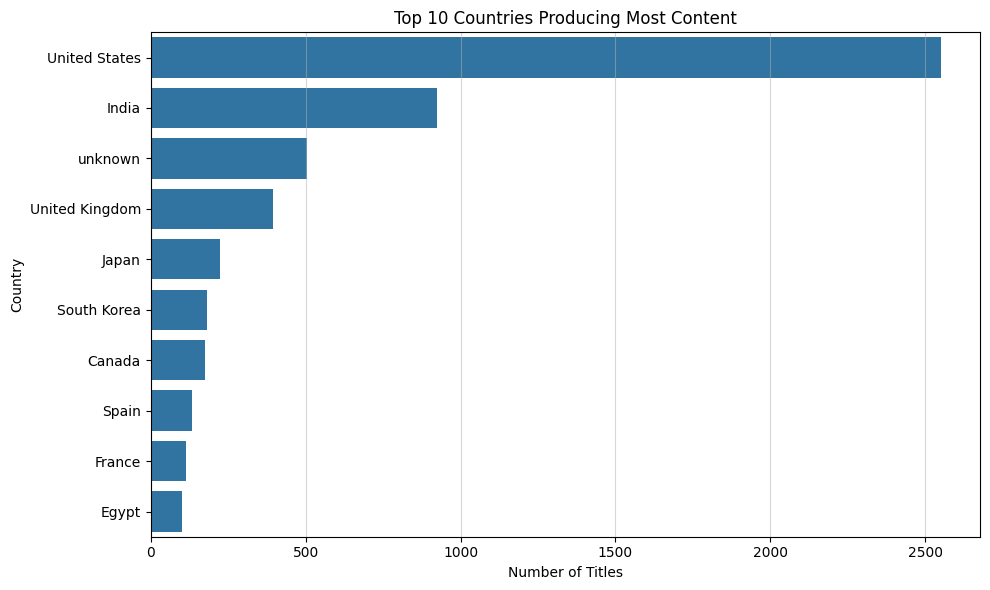

In [22]:
# plotting
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries Producing Most Content')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.show()

Observations:

***United States

Dominates content production with over 3,300 titles.

This makes it the leading country by a significant margin, producing more than triple the amount of the next highest country.

***India

Second place, producing just under 1,000 titles.

India has a robust film and TV industry (Bollywood and regional cinema), which explains the high output.

***United Kingdom

Third on the list, with approximately 700 titles.

The UK has a strong media industry, especially in drama, documentaries, and period pieces.


***Canada, France, Japan, Spain, South Korea, and Germany

Each of these countries contributes between 200 and 400 titles.

These are all countries with notable media industries, particularly in TV, cinema, and animation (e.g., Japan for anime, South Korea for K-dramas).

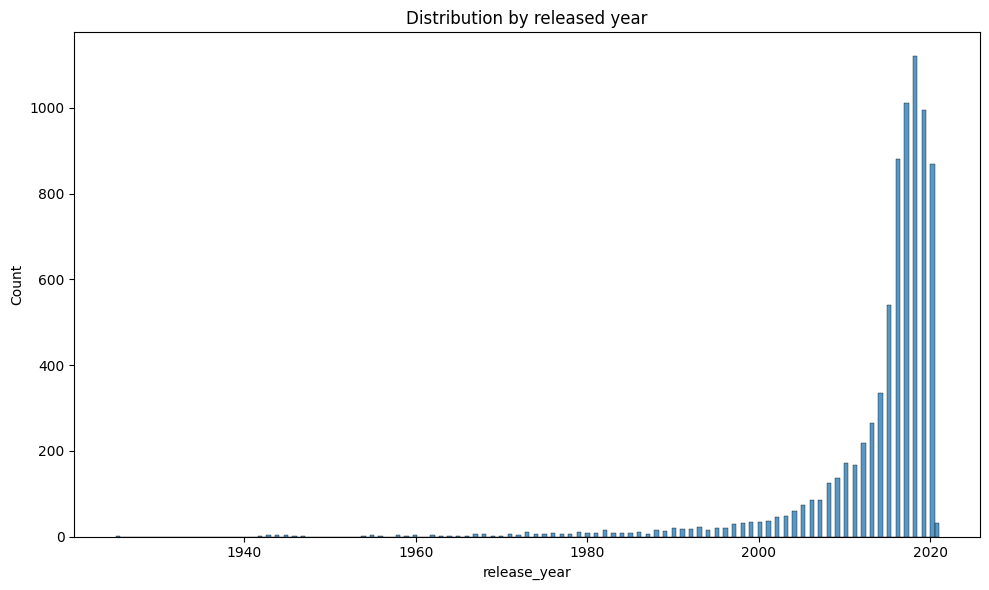

In [23]:
#6.Visualizing the year in which the movie and tv show was released in most

plt.figure(figsize=(10,6))
sns.histplot(df['release_year'])
plt.title('Distribution by released year')
plt.tight_layout()
plt.show()

Observations:

1. Low Activity Before 1980:

  From pre-1930s to around the late 1970s, the release count is very low—bars are almost touching the x-axis.

  Suggests either:

  Few items were released during those years.

  The dataset contains very limited historical data.

2. Gradual Growth:

  From 1980 to around 2000, there's a slow but steady rise in releases.

  Could indicate growing industry trends (e.g., rise of home media, gaming, film, etc.).

3. Rapid Surge After 2000:

  Post-2000, especially from 2010 to 2019, there’s an explosive increase in the number of releases.

  The peak occurs close to 2019, possibly with over 1100 items released that year.

  Likely reflects digital distribution, streaming platforms, or indie content creation boom.

4. Sudden Drop After 2020:

  Sharp decline in 2020, 2021, and 2022.

  Possible reasons:

  COVID-19 pandemic affected release schedules.

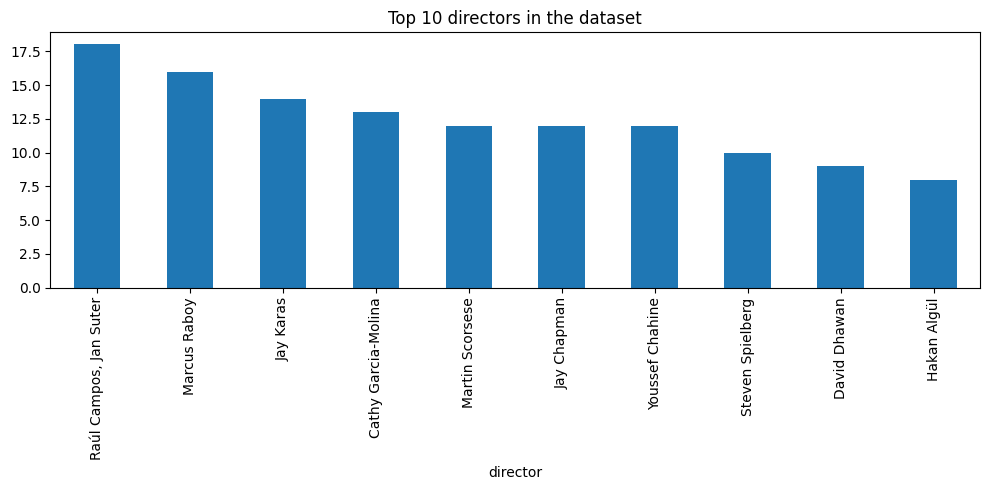

In [24]:
# 7.Top 10 directors in the dataset

plt.figure(figsize=(10,5))
df[(df['director'] !='unknown')].director.value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 directors in the dataset')
plt.tight_layout()
plt.show()

This bar chart shows the top 10 most frequent directors in a dataset.

Raul Campos, Jan Suter directed the most titles (~18).

Others like Marcus Raboy, Jay Karas, and Cathy Garcia-Molina also have high counts.

Well-known names like Steven Spielberg and Martin Scorsese appear too.

The chart helps identify the most active directors in the dataset.

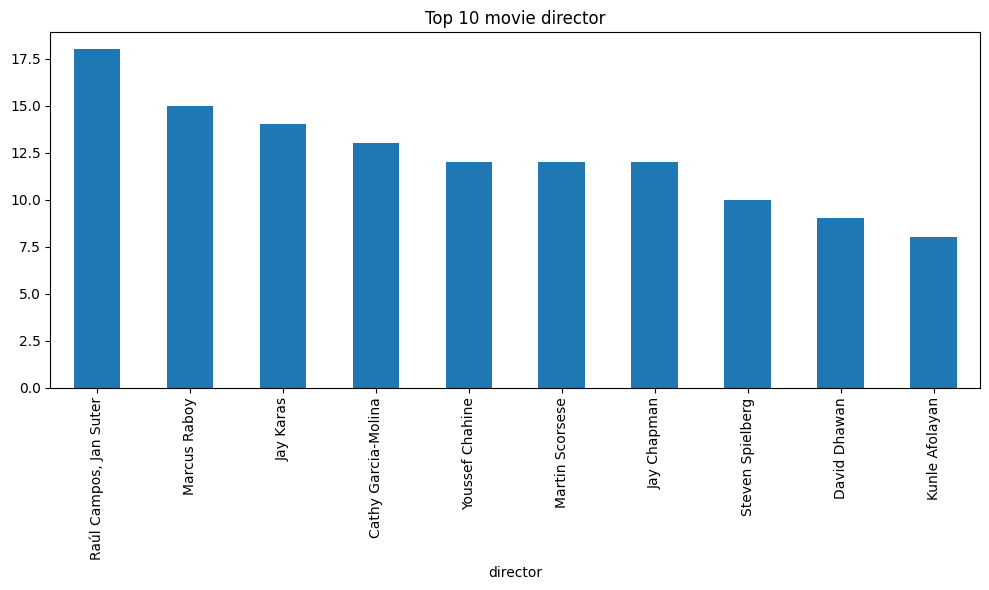

In [25]:
#8.Top ten movie directors
plt.figure(figsize=(10,6))

df[(df['director']!='unknown') & (df['type']=='Movie')].director.value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 movie director')
plt.tight_layout()
plt.show()

Observations:

Raúl Campos and Jan Suter are the most prolific duo in the list, far ahead of others, possibly due to collaborative works.

Marcus Raboy and Jay Karas follow closely behind, indicating they are also very active.

Famous directors like Martin Scorsese and Steven Spielberg are present, but surprisingly not at the very top. This suggests the metric might be based on a specific subset of movies (like Netflix or streaming-specific, or by genre), rather than all-time filmographies.

Directors from different global regions are represented, such as Youssef Chahine (Egypt), David Dhawan (India), and Kunle Afolayan (Nigeria), which may imply a diverse dataset.

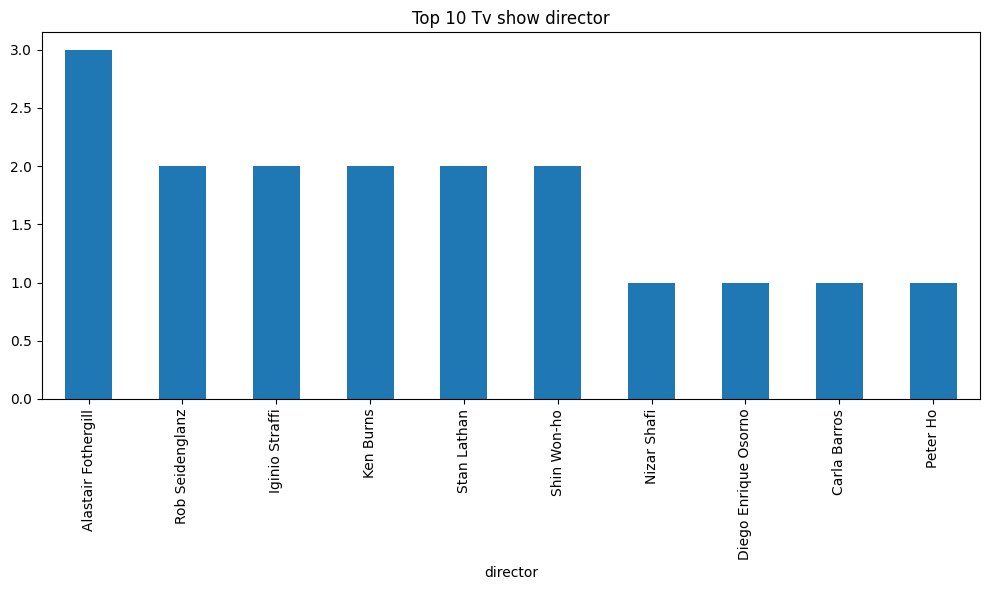

In [26]:
#9.Top 10 Tv show directors

plt.figure(figsize=(10,6))

df[(df['director']!='unknown') & (df['type']=='TV Show')].director.value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 Tv show director')
plt.tight_layout()
plt.show()

Observations:

Overall lower counts than in the movie director chart, suggesting either:

Fewer shows per director in the dataset.

Or a more evenly spread contribution from directors in the TV category.

Alastair Fothergill, known for nature documentaries like Planet Earth, stands out in volume — which aligns with his history of directing multiple documentary series.

There is a mix of international names, implying a diverse global dataset — e.g., Shin Won-ho (Korean dramas), Iginio Straffi (Italian animation), and Ken Burns (American documentaries).



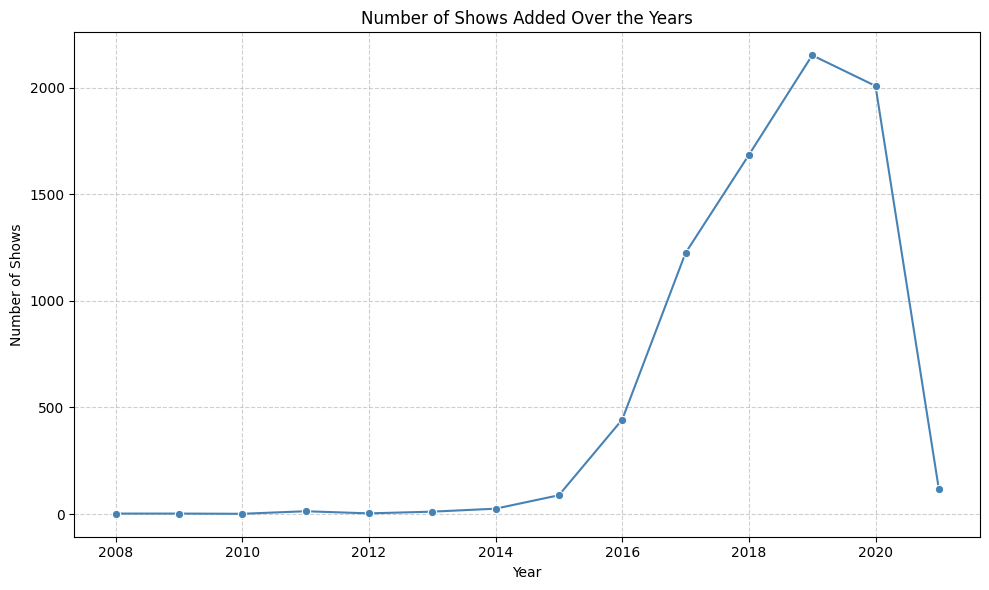

In [27]:
#10.Number of shows added over years 
# Group by year and count the number of shows added
shows_per_year = df['year_added'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=shows_per_year.index, y=shows_per_year.values, marker='o', color='steelblue')

plt.title('Number of Shows Added Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Shows')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Trends & Interpretation:

**2008–2014: Flat & Low Activity

Show additions were minimal — likely due to:

Limited original content.

Smaller global catalog.

Streaming not yet dominant.

**2015–2019: Explosive Growth

This marks the golden age of content addition:

Platforms like Netflix, Hulu, and Amazon Prime were competing aggressively.

Heavy investment in original content.

Global expansion into new markets (e.g., India, Europe, South America).

**2020: Slight Decline

Though still high, this dip likely reflects the COVID-19 pandemic’s impact on production schedules, releases, and filming logistics.



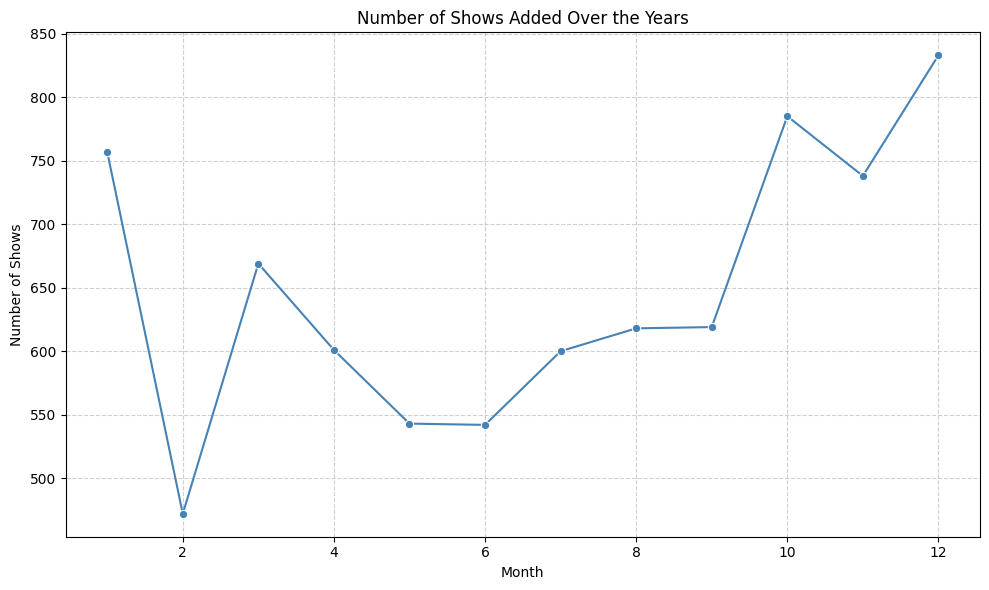

In [28]:
#11.Number of shows added over months
shows_per_month = df['month_added'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x=shows_per_month.index, y=shows_per_month.values, marker='o', color='steelblue')

plt.title('Number of Shows Added Over the Years')
plt.xlabel('Month')
plt.ylabel('Number of Shows')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Key Insights:

**Peak Months:

October, November, December: Highest number of additions.

This likely coincides with:

Fall releases ahead of holidays.

Major end-of-year premieres.

Increased viewer engagement during festive/holiday season.

**Lowest Month:

February: Significantly lower than other months.

Possible reasons:

Fewer days (short month).

Strategic delay in content release.

Slower post-holiday production cycle.

**Overall Trend:

Starts strong in January.

Dips and then stabilizes mid-year (May–September).

Spikes again toward year-end.

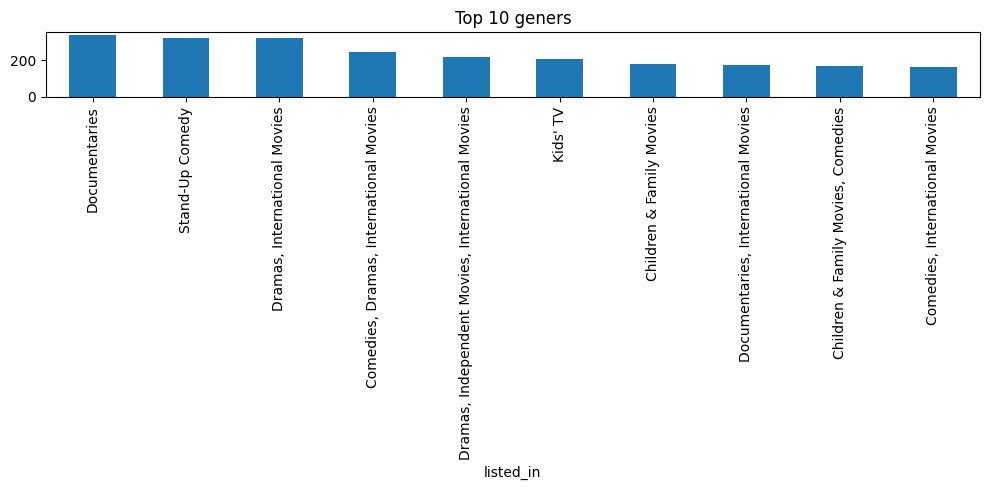

In [29]:
# 12.Top 10 geners in the dataset

plt.figure(figsize=(10,5))
df[~(df['listed_in']=='unknown')].listed_in.value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 geners')
plt.tight_layout()
plt.show()

Insights:

**Dominance of Informational Content:

Documentaries top the list, showing strong demand for non-fiction, educational, or real-world content.

**Comedy Is Key:

Stand-Up Comedy is second, and comedy appears in 4 of the top 10 combinations—audiences consistently seek light-hearted and humorous content.

**Global Appeal:

Many categories include "International Movies", indicating a diverse, global content library and user interest in non-local cinema.

**Family Content:

Kids' TV and Children & Family Movies rank high, showing a strong emphasis on family-friendly viewing.

**Genre Blends Dominate:

Combinations like "Dramas, International Movies" suggest that hybrid genres are more common and better represent viewer interests than single genres alone.



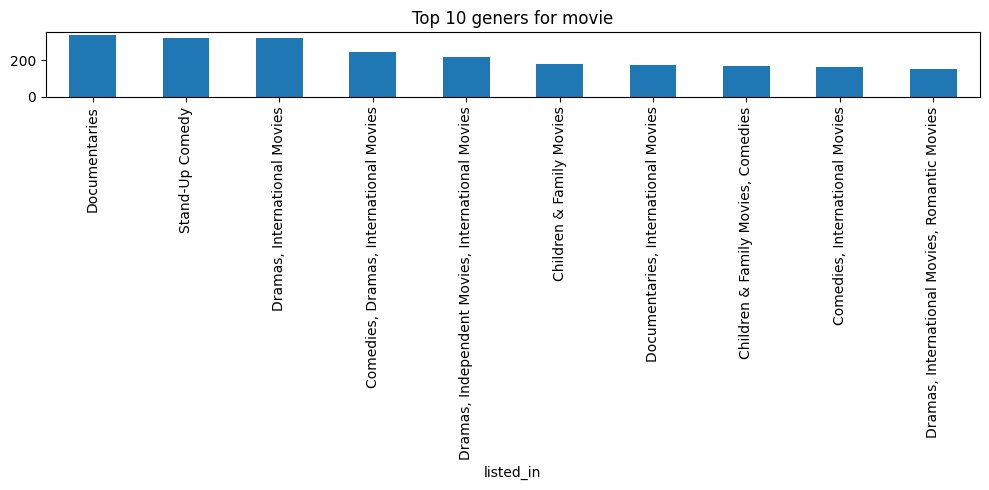

In [30]:
#13.Top 10 gener for movie 
plt.figure(figsize=(10,5))
df[(df['listed_in']!='unknown') & ( df['type']=='Movie')].listed_in.value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 geners for movie')
plt.tight_layout()
plt.show()


Conclusion:

The most popular movie genres on the platform are:

Documentaries and Comedies (especially stand-up),

Blends of Drama + International themes,

Significant representation of Family-friendly and Cross-cultural content.

*These trends suggest the platform is optimizing for:

Global accessibility

Varied audience tastes (from light comedy to informative docs)

Inclusive genres that mix multiple interests.

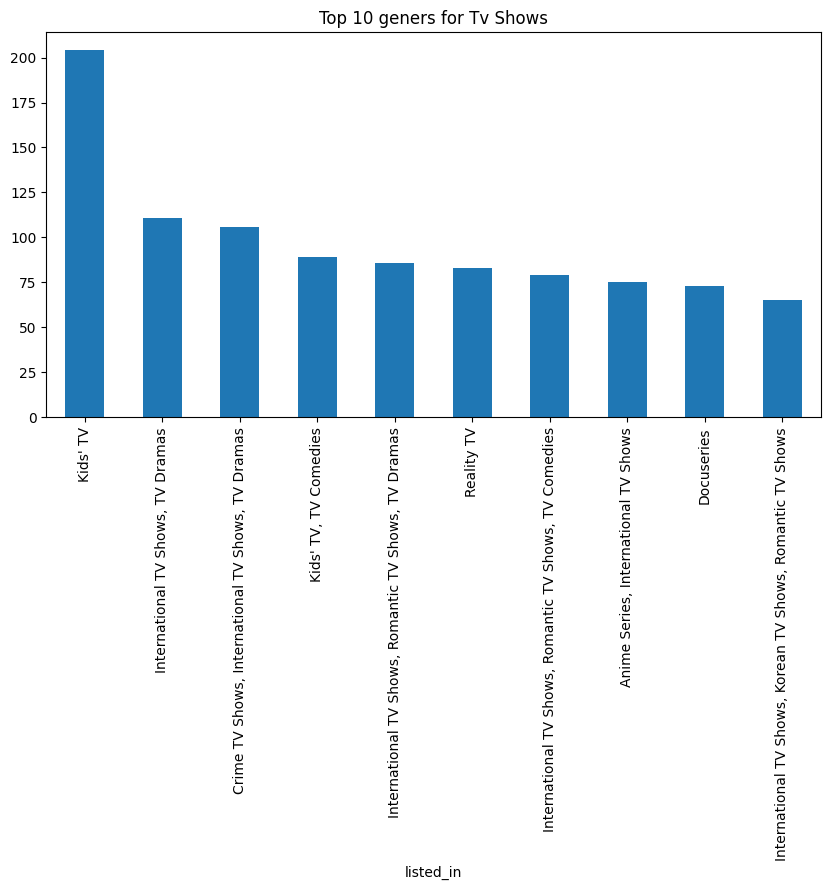

In [31]:
#14.Top 10 gener for Tv shows 
plt.figure(figsize=(10,5))
df[(df['listed_in']!='unknown') & ( df['type']=='TV Show')].listed_in.value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 geners for Tv Shows')
plt.tight_layout()
plt.show()

Conclusion:

*This chart suggests that the streaming platform’s TV catalog heavily emphasizes: Kids’ programming

Globally diverse and multilingual dramas

Romantic themes, especially with Korean and international content

Nonfiction formats like docuseries and reality shows

*These trends align with global audience preferences for both family-oriented and culturally rich TV experiences.

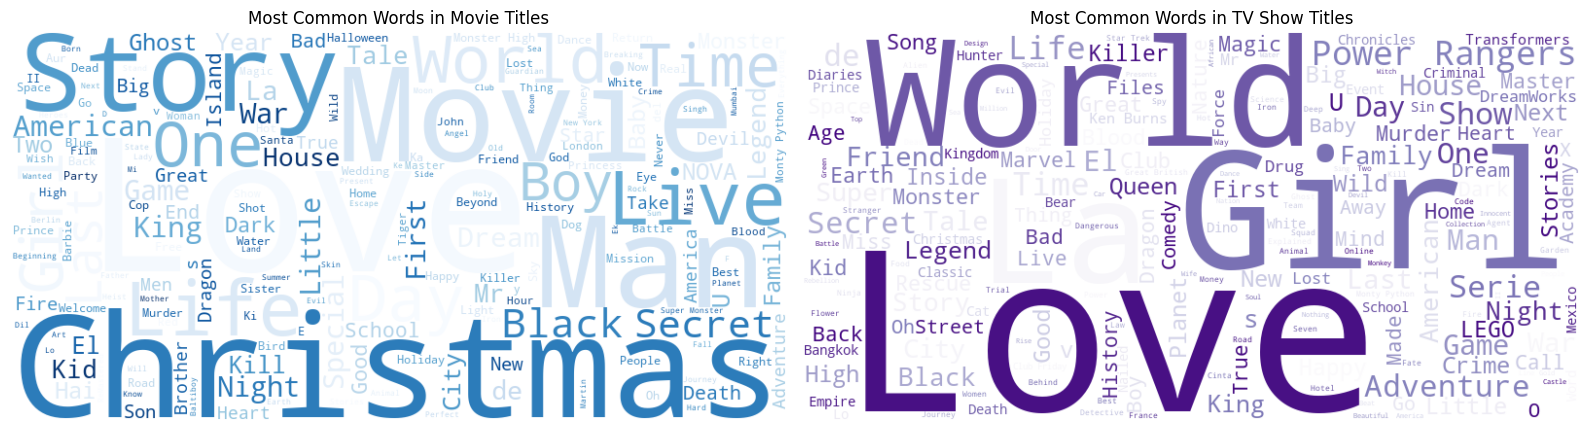

In [32]:
#15.wordcloud to see which words appear the most in the titles for movies and tv shows

# Optional: Set of stopwords to remove common words
stopwords = set(STOPWORDS)

# Titles for Movies
movie_titles = df[df['type'] == 'Movie']['title'].dropna().str.cat(sep=' ')
# Titles for TV Shows
tv_titles = df[df['type'] == 'TV Show']['title'].dropna().str.cat(sep=' ')

# WordCloud for Movies
movie_wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='Blues'
).generate(movie_titles)

# WordCloud for TV Shows
tv_wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='Purples'
).generate(tv_titles)

# Plot both word clouds side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(movie_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Movie Titles')

plt.subplot(1, 2, 2)
plt.imshow(tv_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in TV Show Titles')

plt.tight_layout()
plt.show()

Insights:

*Commonalities:

Both media types use emotive, relational, and dramatic language.

Words like Love, Girl, Story, Man, and World are frequent across both.

*Movies Focus More On:

Self-contained themes like Life, Time, Movie, Dream

More holiday- and occasion-based words: Christmas, Night, Day

*TV Shows Focus More On:

Ongoing formats: Series, Show

Youth and team-based storytelling: Power, Rangers, High, Friend

Action/mystery elements: Murder, Adventure, Monster, Rescue

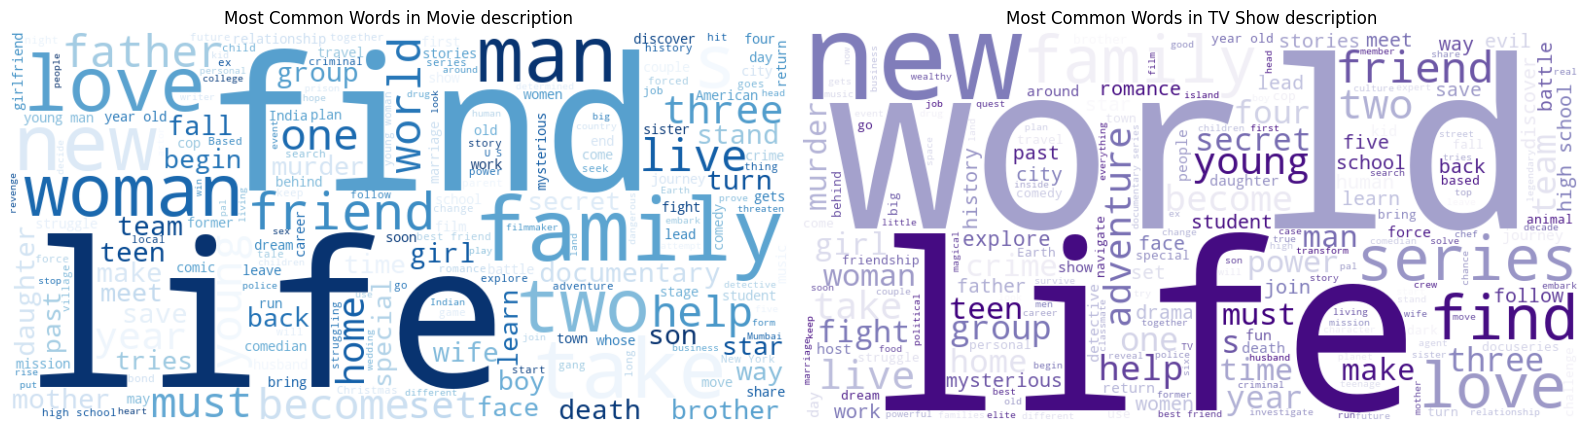

In [33]:
#16.wordcloud to see which words appear the most in the description for movies and tv shows

# Optional: Set of stopwords to remove common words
stopwords = set(STOPWORDS)

# Titles for Movies
movie_description = df[df['type'] == 'Movie']['description'].dropna().str.cat(sep=' ')
# Titles for TV Shows
tv_description= df[df['type'] == 'TV Show']['description'].dropna().str.cat(sep=' ')

# WordCloud for Movies
movie_wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='Blues'
).generate(movie_description)

# WordCloud for TV Shows
tv_wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    stopwords=stopwords,
    colormap='Purples'
).generate(tv_description)

# Plot both word clouds side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(movie_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Movie description')

plt.subplot(1, 2, 2)
plt.imshow(tv_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in TV Show description')

plt.tight_layout()
plt.show()

Insights:

**Movies tend to emphasize personal, emotional, and family-oriented narratives — often centered on a main character’s journey or transformation.

Themes:

Search/Journey: find, discover, travel, search

Relationships: family, friend, father, mother, woman, man, love

Conflict/Challenge: help, fight, death, save, murder, mystery

Temporal: year, new, turn, set, time

**TV Shows highlight group/team-based dynamics, youth and school life, and often involve episodic conflict (e.g., crime, murder, secrets).

Themes:

Group Dynamics: team, group, family, students

Youth-Oriented: young, teen, school, student

Conflict/Drama: fight, crime, murder, challenge, secret

Purpose/Journey: discover, help, navigate, embark, become





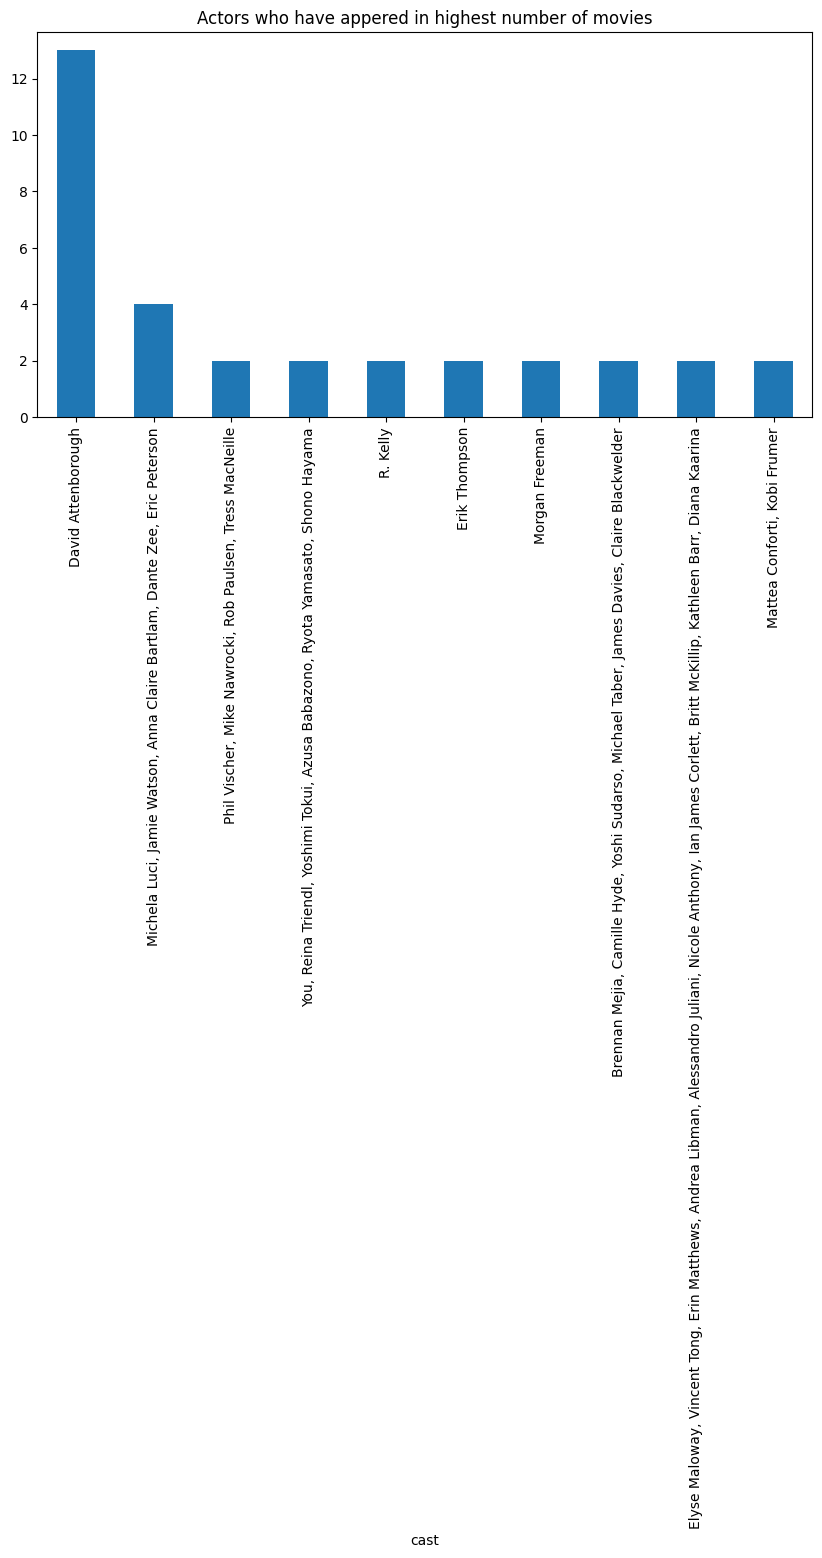

In [34]:
#17.Top actors for Tv shows

plt.figure(figsize=(10,5))
df[(df['cast']!='unknown') & ( df['type']=='TV Show')].cast.value_counts().nlargest(10).plot(kind='bar')
plt.title('Actors who have appered in highest number of movies')
plt.tight_layout()
plt.show()



**David Attenborough – 13 Movies

Significantly ahead of others.

Known for narrating nature documentaries, which explains the high count.

**Other Notable  Names (4–2 movies):

4 Movies: Michela Luci, Jamie Watson, Anna Claire Bartlam, Dante Zee, Eric Peterson

2 Movies Each:Phil Vischer, Mike Nawrocki, Rob Paulsen, Tress MacNeille ,Ryota Yamasato, Shono Hayama, etc.

Erik Thompson, Morgan Freeman, R. Kelly

**Mixed Appearance Types:

Some are voice actors (e.g., Tress MacNeille, Rob Paulsen)

Some are narrators or hosts (e.g., Erik Thompson)

Others are likely from animated/children’s franchises or Power Rangers-style series, based on grouped listings.



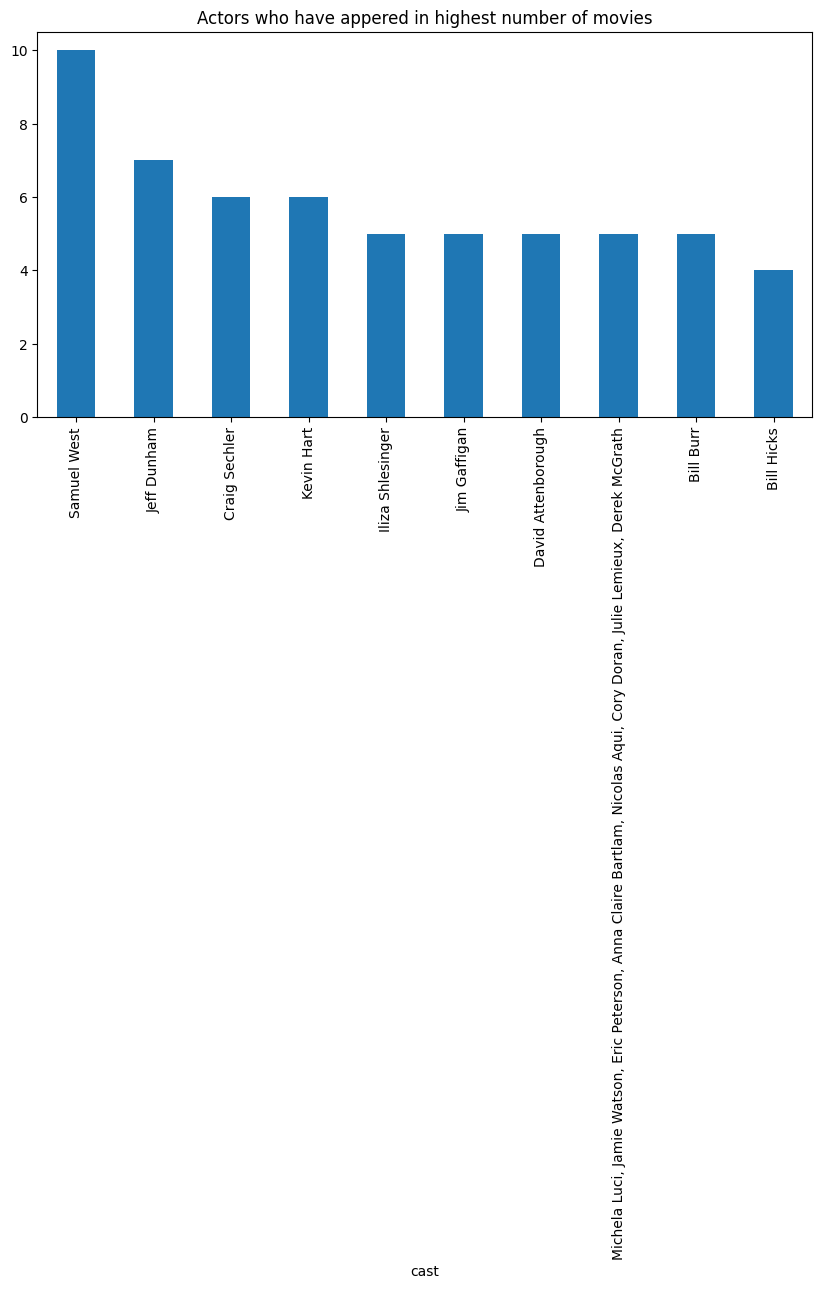

In [35]:
#18.Top actors for Movies

plt.figure(figsize=(10,5))
df[(df['cast']!='unknown') & ( df['type']=='Movie')].cast.value_counts().nlargest(10).plot(kind='bar')
plt.title('Actors who have appered in highest number of movies')
plt.tight_layout()
plt.show()

*Samuel West – 10 movies:

Known for narration in documentaries and historical content.

*Jeff Dunham – 7 movies:

Famous ventriloquist and comedian; likely counting his comedy specials.

*Craig Sechler & Kevin Hart – 6 movies each

Craig Sechler: Often narrates science or educational documentaries.

Kevin Hart: Popular actor/comedian across both stand-up and feature films.

*Others in Top 10 (5–4 Movies Each):

Iliza Shlesinger, Jim Gaffigan, David Attenborough – 5 movies

Derek McGrath, Bill Burr, Bill Hicks – 4 movies

These names are heavily weighted toward stand-up comedians and documentary narrators, suggesting the dataset includes many stand-up specials and non-fiction films.

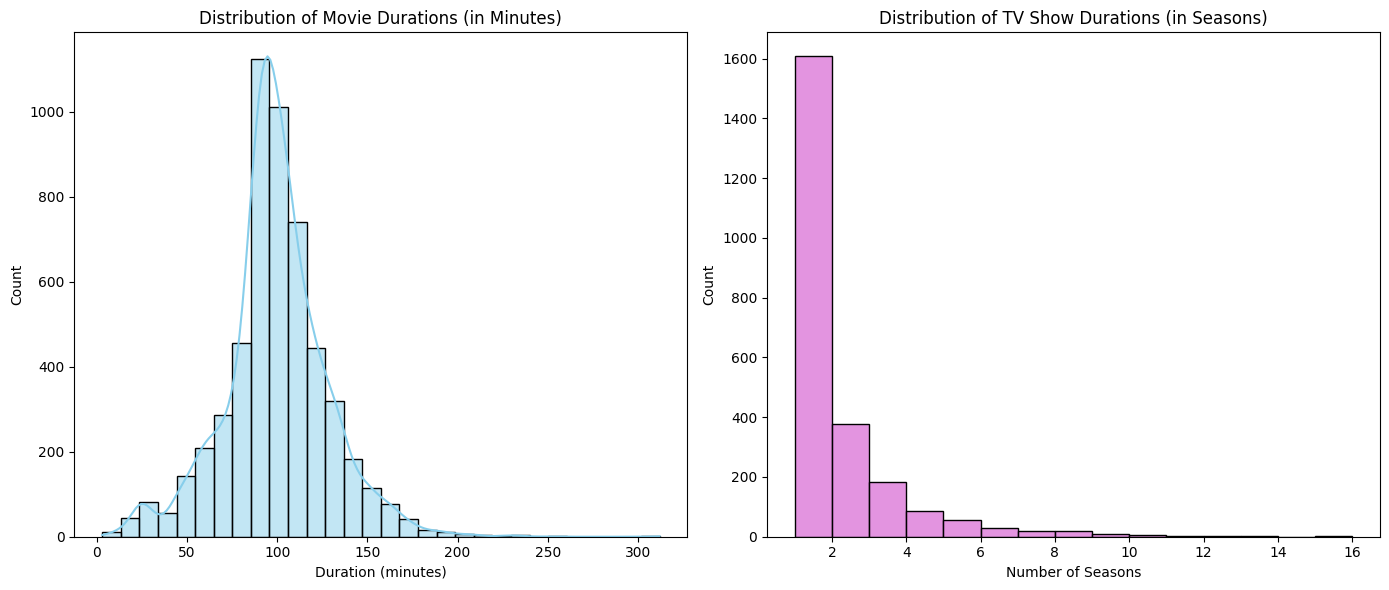

In [36]:
#19.Duration of Movie & Tv Show

# Split the dataset
movies = df[df['type'] == 'Movie'].copy()
tv_shows = df[df['type'] == 'TV Show'].copy()

# Extract numeric duration
movies['duration_minutes'] = movies['duration'].str.extract('(\d+)').astype(float)
tv_shows['duration_seasons'] = tv_shows['duration'].str.extract('(\d+)').astype(float)

# Plotting side-by-side histograms
plt.figure(figsize=(14, 6))

# Histogram for Movie durations
plt.subplot(1, 2, 1)
sns.histplot(movies['duration_minutes'], bins=30, color='skyblue', kde=True)
plt.title('Distribution of Movie Durations (in Minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')

# Histogram for TV Show durations
plt.subplot(1, 2, 2)
sns.histplot(tv_shows['duration_seasons'], bins=15, color='orchid', kde=False)
plt.title('Distribution of TV Show Durations (in Seasons)')
plt.xlabel('Number of Seasons')
plt.ylabel('Count')

plt.tight_layout()
plt.show()




**Left Plot: Movie Durations (in Minutes):

Shape: Approximately normal distribution (bell-shaped), slightly right-skewed.

Peak (Mode): Around 90–100 minutes.

Common Range: Most movies fall between 75–130 minutes.

Tails:

Some shorter movies (~<60 min), possibly documentaries or short films.

Fewer very long films (>180 min).

**Right Plot: TV Show Durations (in Seasons)

Shape: Strong right-skew (long tail).

Peak (Mode): 1 season is by far the most common, suggesting many limited series or short-lived shows.

Trend:

The number of shows drops rapidly after 1 season.

Few shows exceed 6 seasons, with some rare long-runners (~10–15 seasons).

**Key Insights:

Movies are typically clustered around the industry-standard feature length (90–120 mins).

TV Shows are mostly short-lived or designed as miniseries (1–2 seasons dominate).

The tail for TV shows indicates a small subset of long-running, likely popular or syndicated series.

3.Data Preprocessing:

In [37]:
#df1= pd.read_csv("C:/Users/mosel/Documents/PYTHON/machine_learning/Netflix_Movies_and_TV_Shows_Clustering/NETFLIX_MOVIES_AND_TV_SHOWS_CLUSTERING.csv")

In [38]:
df1 = df.copy()

In [39]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7777 entries, 0 to 7786
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7777 non-null   object
 1   type          7777 non-null   object
 2   title         7777 non-null   object
 3   director      7777 non-null   object
 4   cast          7777 non-null   object
 5   country       7777 non-null   object
 6   release_year  7777 non-null   int64 
 7   rating        7777 non-null   object
 8   duration      7777 non-null   object
 9   listed_in     7777 non-null   object
 10  description   7777 non-null   object
 11  month_added   7777 non-null   int32 
 12  year_added    7777 non-null   int32 
dtypes: int32(2), int64(1), object(10)
memory usage: 789.9+ KB


Step 1: Handle missing values in key columns like director, cast, and country by using imputation strategies or removing irrelevant data.


In [40]:
import pandas as pd
import numpy as np

# Replace empty strings or 'NaN' strings with actual np.nan
for col in ['director', 'cast', 'country']:
    df1[col] = df1[col].replace(['', 'NaN', 'nan', None], np.nan)

# Impute missing values with a placeholder
df1['director'].fillna('Unknown Director', inplace=True)
df1['cast'].fillna('Unknown Cast', inplace=True)
df1['country'].fillna('Unknown Country', inplace=True)

Step 2: Convert categorical data (type, rating, listed_in) into numerical format using one-hot encoding or label encoding.


In [41]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in ['type', 'rating', 'listed_in']:
    le = LabelEncoder()
    df1[col + '_enc'] = le.fit_transform(df1[col])
    label_encoders[col] = le  # Store for inverse transform or future use

Step 3: Standardize numerical features such as duration and release_year to ensure uniform scaling.


In [42]:
import re
from sklearn.preprocessing import StandardScaler

# Convert duration to numeric values (e.g., minutes or number of seasons)
def extract_duration(value):
    if 'Season' in value:
        return int(re.search(r'\d+', value).group()) * 60  # Assume 1 season ≈ 60 min
    else:
        return int(re.search(r'\d+', value).group())

df1['duration_num'] = df1['duration'].apply(extract_duration)

# Standardize
scaler = StandardScaler()
df1['release_year_scaled'] = scaler.fit_transform(df1[['release_year']])
df1['duration_scaled'] = scaler.fit_transform(df1[['duration_num']])

Step 4: Extract relevant features from text columns like listed_in and description using Natural Language Processing (NLP) techniques such as TF-IDF vectorization if necessary.


In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re

#  Clean the description column
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text.lower())

df1['description_clean'] = df1['description'].apply(clean_text)

# Vectorize the description using TF-IDF
tfidf = TfidfVectorizer(max_features=50, stop_words='english')  # limit to top 300 words
desc_tfidf = tfidf.fit_transform(df1['description_clean'])  # shape: (n_samples, 300)

4.Feature Engineering

Step 1:

Create new meaningful features, such as:
Content age: current_year - release_year.
Genre count: Number of genres associated with each content.

In [44]:
# Add content_age
current_year = 2025
df1['content_age'] = current_year - df1['release_year']

# Add genre_count
df1['genre_count'] = df1['listed_in'].apply(lambda x: len(x.split(', ')))

5.Clustering Model Selection

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Select cleaned features
X_clean = df1[['type_enc', 'content_age', 'genre_count']]  # Try different combos
#X_clean = df1[['type_enc', 'content_age', 'genre_count','rating_enc','listed_in_enc']]
#X_clean = df1[['type_enc', 'content_age','listed_in_enc']]

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Evaluate
score = silhouette_score(X_pca, labels)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.5141681775833665


K-Means Clustering: Suitable for numerical data; requires selecting the optimal number of clusters using the Elbow Method or Silhouette Score.

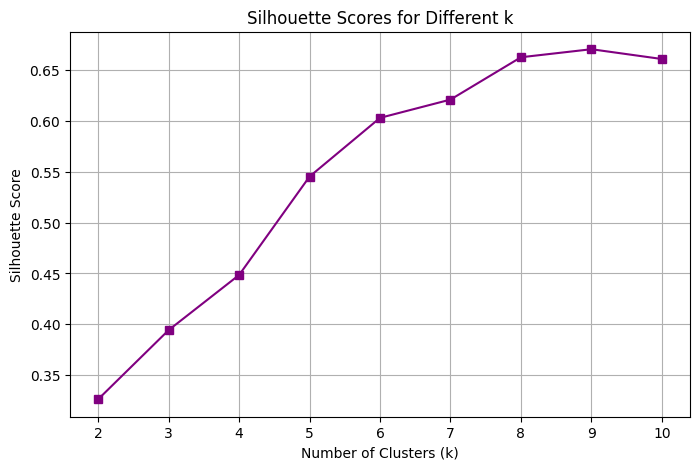

In [46]:
# Silhouette Score 
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker='s', color='purple')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()



What is Silhouette Score?

The Silhouette Score measures how well each point fits within its assigned cluster compared to other clusters.

Range: -1 to 1

Interpretation:

+1 → Perfect clustering (points far from other clusters)

0 → Overlapping clusters (indistinct)

Negative → Wrong clustering (points assigned to wrong clusters)

Insights from the Chart:

The silhouette score increases from k=2 to k=9.

Peaks at k=9 with the highest score, indicating the best-defined clustering at that point.

Slight drop at k=10 suggests diminishing returns or overfitting past 9 clusters.

Conclusion:

The optimal number of clusters appears to be k = 9, as it gives the highest silhouette score, suggesting that the data is best grouped into 9 clusters.

In [47]:
#Final KMeans Model with Optimal K 

optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df1['cluster'] = kmeans.fit_predict(X_scaled)

6.Model Training & Optimization

Use dimensionality reduction techniques like Principal Component Analysis (PCA) or t-SNE to visualize clusters in 2D or 3D.

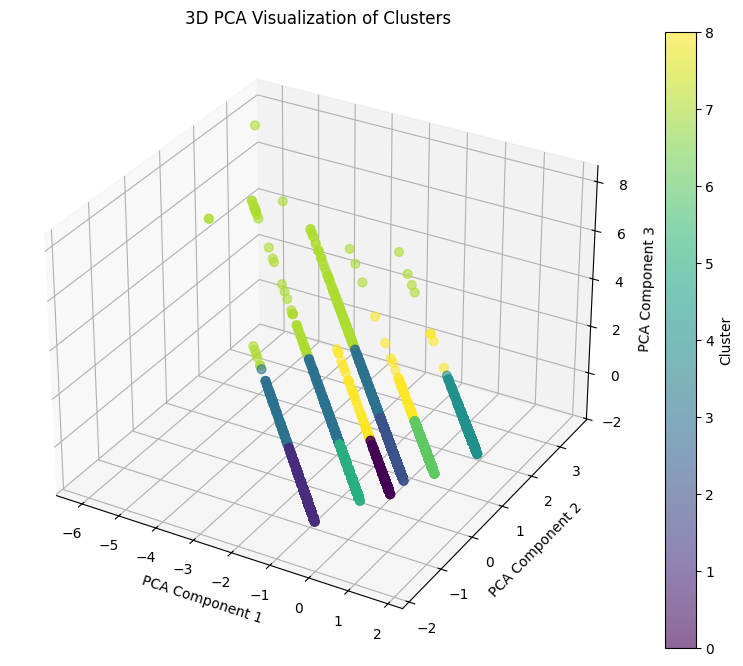

In [ ]:
# PCA Visualization

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PCA to 2D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot with cluster coloring
scatter = ax.scatter(
    X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
    c=df1['cluster'], cmap='viridis', alpha=0.6, s=40
)

# Label axes
ax.set_title('3D PCA Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Colorbar for clusters
fig.colorbar(scatter, label='Cluster')

plt.show()


What This Visualization Tells You:

Clustering Structure:

The clusters are visibly distinct along vertical stripes, showing strong separation in the PCA space — a good sign that your clustering algorithm performed well.

Vertical Grouping by Cluster:

Each vertical “stripe” of points seems to represent a different cluster — showing a strong pattern along the PCA Component 3 axis.

The clusters are fairly well-separated, with minimal overlap, indicating that PCA preserved enough structure to distinguish them visually.

Conclusion:

Your data has been successfully clustered into 9 groups (based on your silhouette plot).

This 3D PCA plot confirms that these clusters are well-separated and distinct in the reduced-dimensional space.

In [49]:
print("Explained variance ratio:", pca_3d.explained_variance_ratio_)
print("Total variance explained:", sum(pca_3d.explained_variance_ratio_))

Explained variance ratio: [0.39241355 0.34698363 0.26060282]
Total variance explained: 1.0


What Is PCA?

Principal Component Analysis (PCA) is a dimensionality reduction technique. It transforms your original (possibly high-dimensional) data into a new set of orthogonal (uncorrelated) variables called principal components, ordered by how much variance they capture.

Why Do We Care About Variance in PCA?

Because:

PCA is all about capturing the most important information in the data — and variance is how we define "importance".

Variance in this context means how much the data spreads out. More variance = more information or structure.

Explained Variance Ratio — What It Means

Definition:

The explained variance ratio for each principal component tells you how much of the original data's variability (spread/information) is captured by that component.

Example:

Explained variance ratio: [0.50, 0.30, 0.20]
PC1 explains 50% of the total variance.

PC2 explains 30%.

PC3 explains 20%.

Total variance explained = 100%

Why We Calculate It — 4 Reasons

1. Dimensionality Reduction
Suppose you have 100 features, but the first 10 PCs explain 95% of the variance.

You can safely reduce your data from 100 to 10 dimensions, keeping almost all of the important information.

This helps speed up models, avoid overfitting, and visualize high-dimensional data.

2. Noise Filtering
Later components (with low explained variance) often represent noise or tiny fluctuations in the data.

By dropping components that explain little variance, you reduce the effect of noise and focus on meaningful structure.

3. Interpretability
Explained variance helps you understand how much information you're keeping or losing.

If the first 2 components explain 95% of the variance, you're doing great. If they explain only 50%, you might need more.

4. Visualization
We often reduce data to 2D or 3D using PCA for plotting.

Knowing the explained variance tells you how much of the data's "story" is captured in that plot.



Analogy: Compressing an Image

Imagine you’re compressing a high-resolution image:

You want to keep the main patterns (shapes/colors), but throw away tiny, irrelevant pixels.

PCA helps decide which parts of the data (components) are worth keeping — and that’s what explained variance tells you.

7.Visualization & Interpretation:

Step 1:Create heatmaps to show correlations between features and clusters.


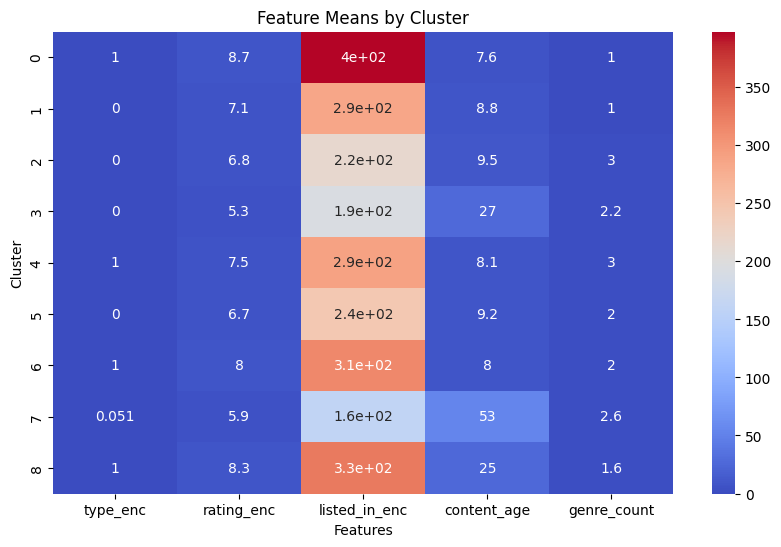

In [50]:
# heatmap to visualize feature distribution across clusters
# Group by cluster and get mean of features
cluster_summary = df1.groupby('cluster')[['type_enc', 'rating_enc', 'listed_in_enc', 'content_age', 'genre_count']].mean()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm')
plt.title('Feature Means by Cluster')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()




| Cluster | Type      | Rating | Age      | Genres | Summary                 |
| ------- | --------- | ------ | -------- | ------ | ----------------------- |
| 0       | Movie     | High   | New      | 1      | Popular, recent movies  |
| 1       | TV Show   | Avg    | New      | 1      | Recent TV shows         |
| 2       | TV Show   | Avg    | New      | 3      | Genre-rich newer shows  |
| 3       | TV Show   | Low    | Old      | 2.2    | Old, poorly rated shows |
| 4       | Movie     | Good   | New      | 3      | Modern, diverse movies  |
| 5       | TV Show   | Avg    | New      | 2      | Balanced TV content     |
| 6       | Movie     | High   | New      | 2      | Well-rated new movies   |
| 7       | Mostly TV | Low    | Very Old | 2.6    | Ancient TV shows        |
| 8       | Movie     | High   | Old      | 1.6    | Old but quality movies  |


Step 2:Present insights derived from clusters, such as the most common genres per group or the distribution of content ratings.


In [51]:
# Insight 1: Most common Genres Per Cluster

# Count top geners per cluster 

top_genres = df1.groupby('cluster')['listed_in'].apply(lambda x: x.mode()[0])
print("Most common genre per cluster:\n", top_genres)

Most common genre per cluster:
 cluster
0                                             Kids' TV
1                                        Documentaries
2               Comedies, Dramas, International Movies
3                   Children & Family Movies, Comedies
4    Crime TV Shows, International TV Shows, TV Dramas
5                         Dramas, International Movies
6                    International TV Shows, TV Dramas
7         Classic Movies, Dramas, International Movies
8                                             Kids' TV
Name: listed_in, dtype: object


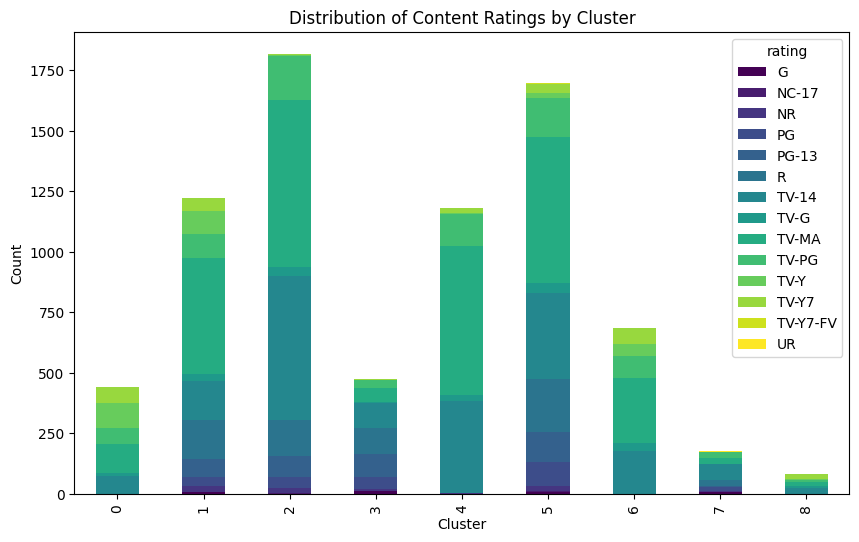

In [52]:
# Insight 2: Distribution of content Rating 

# Count of ratings per cluster
rating_dist = pd.crosstab(df1['cluster'], df1['rating'])
rating_dist.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10,6))
plt.title('Distribution of Content Ratings by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

| Color         | Rating   | Meaning                              |
| ------------- | -------- | ------------------------------------ |
| Dark purple   | G        | General audiences                    |
| Purple        | NC-17    | Adults only (no one 17 and under)    |
| Indigo        | NR       | Not rated                            |
| Blue          | PG       | Parental guidance suggested          |
| Light blue    | PG-13    | Parents strongly cautioned           |
| Teal          | R        | Restricted (under 17 requires adult) |
| Aqua          | TV-14    | Unsuitable for children under 14     |
| Light aqua    | TV-G     | General audience (TV)                |
| Greenish blue | TV-MA    | Mature audience only                 |
| Light green   | TV-PG    | Parental guidance (TV)               |
| Lime green    | TV-Y     | Suitable for all children            |
| Yellow green  | TV-Y7    | Suitable for children 7 and older    |
| Yellow        | TV-Y7-FV | Fantasy violence content             |
| Bright yellow | UR       | Unrated                              |


Insights by Cluster:

Here are some key takeaways:

Cluster 2 and Cluster 5 have the highest number of items, heavily dominated by TV-MA (mature content).

Cluster 1 and Cluster 4 also have large numbers, again with strong contributions from TV-14 and TV-MA.

Cluster 0 and Cluster 3 are much smaller but have a more even spread of ratings, suggesting a more mixed type of content.

Cluster 6 has a moderate count, with visible segments of TV-G, TV-Y7, and TV-PG, indicating more family-friendly or children’s content.

Cluster 7 and Cluster 8 are the smallest, likely containing outliers or rare content types.

TV-MA, TV-14, and R are dominant across the larger clusters — implying a strong trend of mature content in the dataset.

In [53]:
# Insight 3: Age Suitability per Cluster 
age_dist = df1.groupby('cluster')['content_age'].mean()
print("Average content age per cluster:\n", age_dist)


Average content age per cluster:
 cluster
0     7.614512
1     8.810303
2     9.541552
3    26.651163
4     8.132091
5     9.154299
6     7.962099
7    52.834286
8    25.457831
Name: content_age, dtype: float64


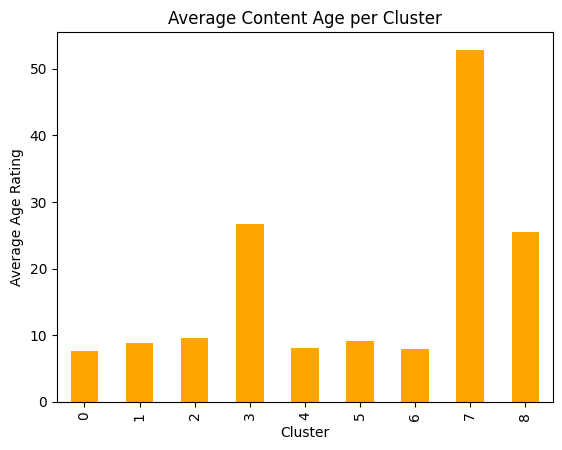

In [54]:
age_dist.plot(kind='bar', color='orange')
plt.title('Average Content Age per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Age Rating')
plt.show()

 Cluster-by-Cluster Analysis:

| Cluster | Average Age Rating | Interpretation                                                      |
| ------- | ------------------ | ------------------------------------------------------------------- |
| **0**   | \~7.5              | Skews toward family/kid-friendly content.                           |
| **1**   | \~9                | Slightly older audience, likely PG or PG-13.                        |
| **2**   | \~10               | Similar to Cluster 1, skewing teen-oriented.                        |
| **3**   | **\~27**           | Much older/mature audience – likely includes R, TV-MA content.      |
| **4**   | \~8                | Again, fairly light content.                                        |
| **5**   | \~9                | Family to young adult audience.                                     |
| **6**   | \~8                | Same range as Clusters 0, 4.                                        |
| **7**   | **\~53**           | Extremely mature content; possibly many unrated/NC-17/adult titles. |
| **8**   | \~26               | Similar to Cluster 3 – older audience focus.                        |


Summary:

This chart gives a clear indication of how age-appropriate or mature the content in each cluster is, with:

Clusters 0, 1, 2, 4, 5, 6 → Family to Teen

Clusters 3 and 8 → Adult/Mature

Cluster 7 → Extreme/Mature or Special Cases

8.Evaluation & Refinement:

Use metrics such as Silhouette Score, Davies-Bouldin Index, and Inertia to validate clustering effectiveness.


In [55]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette = silhouette_score(X_scaled, df1['cluster'])
ch_score = calinski_harabasz_score(X_scaled, df1['cluster'])
db_score = davies_bouldin_score(X_scaled, df1['cluster'])

print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Score: {ch_score}")
print(f"Davies-Bouldin Score: {db_score}")

Silhouette Score: 0.6707975338714428
Calinski-Harabasz Score: 9578.356625346707
Davies-Bouldin Score: 0.6541048887631177


Clustering Evaluation Metrics Explained:

These scores are used to evaluate the quality of clustering when we don’t have ground truth labels (unsupervised learning).

1. Silhouette Score

Value: 0.6708
Range: -1 to 1

What it measures:
How similar a point is to its own cluster (cohesion) compared to other clusters (separation).

Interpretation:

* 0.7: Excellent structure

* 0.5–0.7: Good clustering

* < 0.5: Possibly overlapping or wrong clusters

Your value (0.67) means:

* Your clustering is good — data points are well grouped and well separated.

2. Calinski-Harabasz Index (Variance Ratio Criterion)

Value: 9578.36

Range: 0 to ∞ (higher is better)

What it measures:

The ratio of between-cluster dispersion to within-cluster dispersion.

Interpretation:

Higher values = better-defined clusters

Sensitive to the number of clusters and dimensionality

Your value (9578+) means:

*  Excellent separation and tightness. A very good clustering result, especially if this value increases significantly over other k-values.

3. Davies-Bouldin Score

Value: 0.6541
Range: 0 to ∞ (lower is better)

What it measures:

Similarity between clusters — how well clusters are separated and compact.

Interpretation:

0 = ideal separation

Lower values = better clustering

Your value (0.65) means:

* Good cluster separation — clusters are relatively distinct and well formed.

| Metric                  | Your Score | Evaluation                               |
| ----------------------- | ---------- | ---------------------------------------- |
| Silhouette Score        | 0.6708     |  Good – well-separated clusters         |
| Calinski-Harabasz Score | 9578.36    |  Excellent – distinct, compact clusters |
| Davies-Bouldin Score    | 0.6541     |  Good – low inter-cluster similarity    |


Final Insight:

These three scores together suggest the clustering is well-formed, meaningful, and strongly separated, especially for unsupervised data. Likely chosen a good number of clusters ( k = 9 )

In [56]:

# Pickle the file 

df1.to_pickle("df1.pkl")

In [57]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrame
df1 = pd.read_pickle("df1.pkl")

st.title("Netflix Content Clustering Dashboard")

# Average Content Age per Cluster
st.subheader("📊 Average Content Age per Cluster")
avg_age = df1.groupby("cluster")["content_age"].mean()
st.bar_chart(avg_age)

# Rating Distribution by Cluster
st.subheader("📉 Rating Distribution by Cluster")
rating_counts = df1.groupby(["cluster", "rating"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))
rating_counts.plot(kind="bar", stacked=True, ax=ax)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Distribution of Content Ratings by Cluster")
st.pyplot(fig)


# Filter Shows by Title, Age, Rating

st.subheader("🔎 Filter Shows by Title, Age, and Rating")

# Title Search
title_input = st.text_input("Search Title (partial or full)", "").strip().lower()

# Age Range Slider
min_age = int(df1["content_age"].min())
max_age = int(df1["content_age"].max())
age_range = st.slider("Select Content Age Range", min_age, max_age, (min_age, max_age))

# Rating Multiselect
all_ratings = sorted(df1["rating"].dropna().unique())
selected_ratings = st.multiselect("Select Ratings", all_ratings, default=all_ratings)

# Apply Filters
filtered = df1[
    df1["title"].str.lower().str.contains(title_input) &
    df1["content_age"].between(age_range[0], age_range[1]) &
    df1["rating"].isin(selected_ratings)
]

st.write(f"🎬 {len(filtered)} shows match your filters.")
st.dataframe(filtered[['title', 'rating', 'listed_in', 'content_age']].reset_index(drop=True))

Overwriting app.py


In [58]:
!streamlit run app.py

^C
